In [4]:
import scanpy as sc

In [5]:
adata = sc.read_h5ad('../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata.layers['raw'].max()

1401.0

In [7]:
def gene_counts_per_celltype_distance(
    adata,
    gene,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    layer=None,
    use_raw=True
):
    """
    For a given gene, compute per (celltype, distance_bin):
      - total counts of the gene
      - number of cells
      - mean counts per cell
    """
    from scipy import sparse
    import numpy as np
    import pandas as pd

    # choose matrix and var_names
    if use_raw:
        if adata.raw is None:
            raise ValueError("use_raw=True but adata.raw is None")
        X = adata.raw.X
        var_names = np.asarray(adata.raw.var_names)
    elif layer is not None:
        X = adata.layers[layer]
        var_names = np.asarray(adata.var_names)
    else:
        X = adata.X
        var_names = np.asarray(adata.var_names)

    # locate gene index
    if gene not in var_names:
        raise ValueError(f"Gene {gene} not found in var_names")
    g_idx = np.where(var_names == gene)[0][0]

    # extract gene counts per cell
    if sparse.issparse(X):
        gene_counts = np.asarray(X[:, g_idx].toarray()).ravel()
    else:
        gene_counts = np.asarray(X[:, g_idx]).ravel()

    # assemble df
    df = adata.obs[[celltype_col, distance_col]].copy()
    df["gene_counts"] = gene_counts

    grouped = (df.groupby([celltype_col, distance_col])
                 .agg(total_gene_counts=("gene_counts", "sum"),
                      n_cells=(celltype_col, "count"))
                 .reset_index())

    grouped["mean_gene_counts_per_cell"] = (
        grouped["total_gene_counts"] / grouped["n_cells"]
    )

    grouped["gene"] = gene
    return grouped

In [8]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Slc16a3",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

,celltype_merged,lesion_distance_bin,total_gene_counts,n_cells,mean_gene_counts_per_cell,gene
7,Astrocyte,0–10µm,654.0,2554,0.256069,Slc16a3
8,Astrocyte,10–25µm,372.0,1316,0.282675,Slc16a3
9,Astrocyte,25–50µm,535.0,2233,0.239588,Slc16a3
10,Astrocyte,50–100µm,879.0,4118,0.213453,Slc16a3
11,Astrocyte,100–200µm,1193.0,8410,0.141855,Slc16a3
12,Astrocyte,200–500µm,2112.0,26481,0.079755,Slc16a3
13,Astrocyte,>500µm,1772.0,33846,0.052355,Slc16a3


In [9]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Ldha",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

,celltype_merged,lesion_distance_bin,total_gene_counts,n_cells,mean_gene_counts_per_cell,gene
7,Astrocyte,0–10µm,1944.0,2554,0.761159,Ldha
8,Astrocyte,10–25µm,1202.0,1316,0.913374,Ldha
9,Astrocyte,25–50µm,1894.0,2233,0.848186,Ldha
10,Astrocyte,50–100µm,3138.0,4118,0.762020,Ldha
11,Astrocyte,100–200µm,5476.0,8410,0.651130,Ldha
12,Astrocyte,200–500µm,14867.0,26481,0.561421,Ldha
13,Astrocyte,>500µm,17313.0,33846,0.511523,Ldha


In [10]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


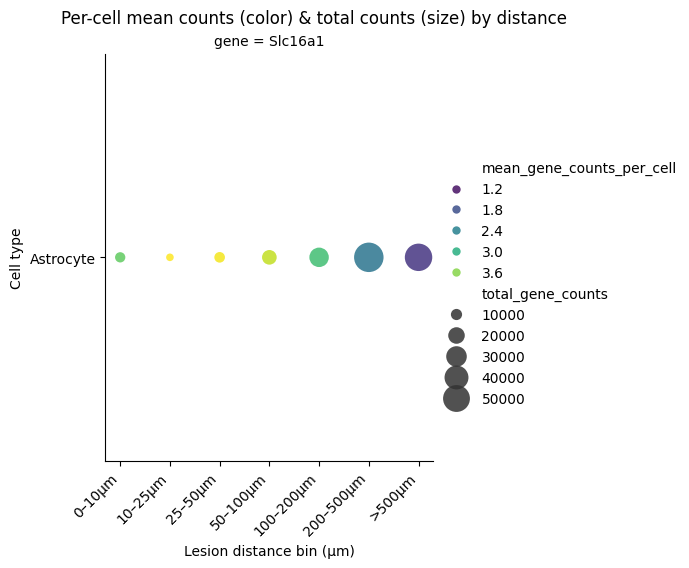

In [11]:
import re, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy import sparse

# --- helper: compute per-gene counts by (celltype, distance bin)
def gene_counts_per_celltype_distance(adata, gene, celltype_col="celltype_merged",
                                      distance_col="lesion_distance_bin",
                                      use_raw=False, layer="raw"):
    if use_raw:
        if adata.raw is None: raise ValueError("use_raw=True but adata.raw is None")
        X = adata.raw.X; var_names = np.asarray(adata.raw.var_names)
    else:
        X = adata.layers[layer] if layer is not None else adata.X
        var_names = np.asarray(adata.var_names)

    if gene not in var_names:
        return pd.DataFrame(columns=[celltype_col, distance_col, "total_gene_counts", "n_cells",
                                     "mean_gene_counts_per_cell", "gene"])

    g_idx = np.where(var_names == gene)[0][0]
    if sparse.issparse(X):
        # ensure subscriptable & dense col
        X = X.tocsr()
        gene_counts = np.asarray(X[:, g_idx].toarray()).ravel()
    else:
        gene_counts = np.asarray(X[:, g_idx]).ravel()

    df = adata.obs[[celltype_col, distance_col]].copy()
    df["gene_counts"] = gene_counts

    out = (df.groupby([celltype_col, distance_col], dropna=False)
             .agg(total_gene_counts=("gene_counts","sum"),
                  n_cells=(celltype_col,"count"))
             .reset_index())
    out["mean_gene_counts_per_cell"] = out["total_gene_counts"] / out["n_cells"].replace(0, np.nan)
    out["gene"] = gene
    return out

# --- helper: natural sort of distance bins like "0-25 µm", "25-50 µm", ...
def _bin_key(s):
    if s is None or (isinstance(s, float) and np.isnan(s)): return (float("inf"),)
    m = re.search(r"(\d+)", str(s))
    return (int(m.group(1)) if m else float("inf"),)

# --- main: build tidy df for selected genes & celltypes and plot
def plot_distance_dotplot(adata, genes_subset, celltypes_subset=None,
                          celltype_col="celltype_merged", distance_col="lesion_distance_bin",
                          use_raw=False, layer="raw", sizes=(20, 300), cmap="viridis"):
    # gather
    frames = []
    for g in genes_subset:
        frames.append(
            gene_counts_per_celltype_distance(
                adata, g, celltype_col=celltype_col, distance_col=distance_col,
                use_raw=use_raw, layer=layer
            )
        )
    df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    # subset cell types (optional)
    if celltypes_subset is not None:
        df = df[df[celltype_col].isin(celltypes_subset)].copy()

    # order axes
    # distance bins
    bins = sorted(df[distance_col].dropna().unique(), key=_bin_key)
    df[distance_col] = pd.Categorical(df[distance_col], categories=bins, ordered=True)
    # celltypes (keep provided order if subset given, else alphabetical)
    if celltypes_subset is not None:
        df[celltype_col] = pd.Categorical(df[celltype_col], categories=celltypes_subset, ordered=True)
    else:
        df[celltype_col] = pd.Categorical(df[celltype_col], ordered=True)

    # plot (one column per gene)
    g = sns.relplot(
        data=df,
        x=distance_col, y=celltype_col,
        hue="mean_gene_counts_per_cell",
        size="total_gene_counts",
        col="gene", kind="scatter",
        palette=cmap, sizes=sizes, alpha=0.85, edgecolor="none"
    )
    g.set_xticklabels(rotation=45, ha="right")
    g.set_ylabels("Cell type")
    g.set_xlabels("Lesion distance bin (µm)")
    g.figure.suptitle("Per-cell mean counts (color) & total counts (size) by distance", y=1.02)
    plt.show()
    return df  # return the tidy data used for the plot

# --- usage examples ---
# choose any subset you like:
genes_subset = ["Slc16a1"]
celltypes_subset = ["Astrocyte"]  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)
# df_dot contains total_gene_counts, n_cells, mean_gene_counts_per_cell per (celltype, bin, gene)

In [12]:
adata.obs.celltype_merged.unique()

['Neuron', 'T cell', 'APC/Myeloid', 'B cell', 'Monocyte', ..., 'Dendritic cell', 'Mixed glia-vascular', 'T cell (cycling)', 'Fibroblast (cycling)', 'Metabolic-like']
Length: 21
Categories (21, object): ['APC/Myeloid', 'Astrocyte', 'B cell', 'Dendritic cell', ..., 'Oligodendrocyte', 'Pericyte', 'T cell', 'T cell (cycling)']

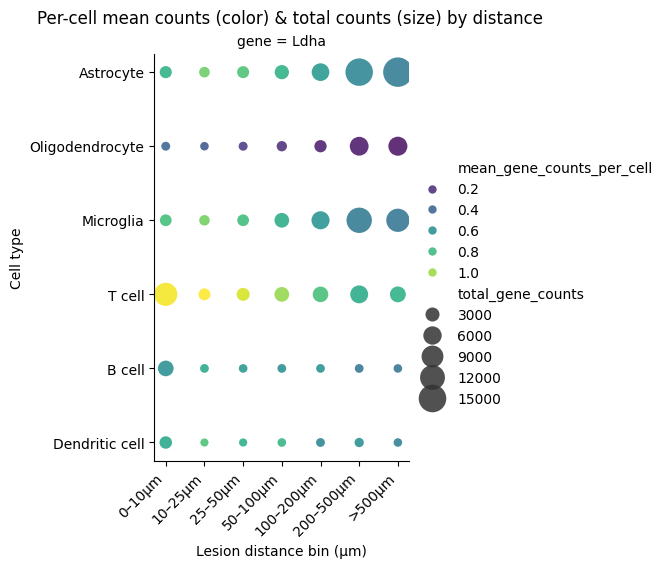

In [13]:
genes_subset = ["Ldha"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

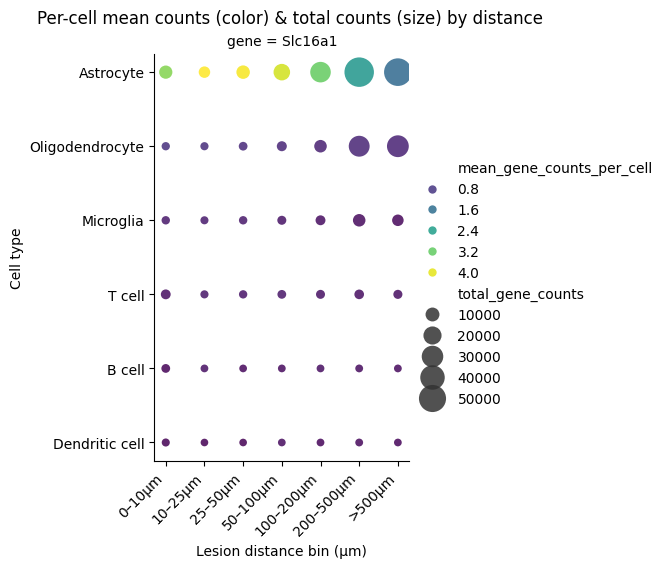

In [14]:
genes_subset = ["Slc16a1"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

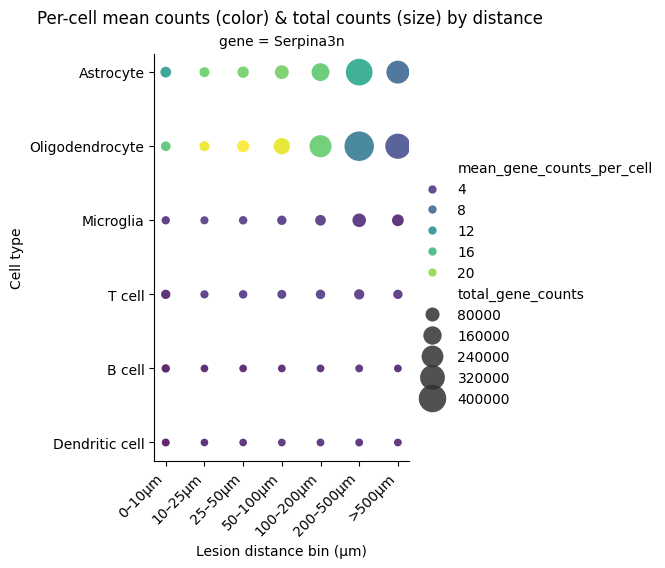

In [15]:
genes_subset = ["Serpina3n"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

In [16]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


Neuron


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


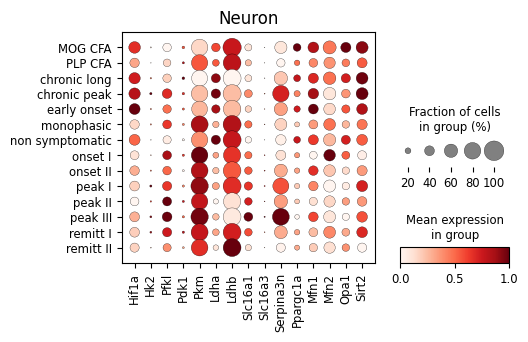

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


T cell


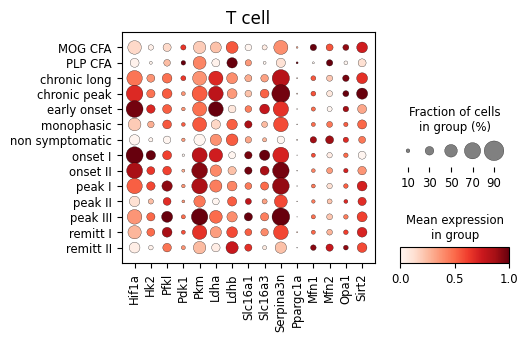

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


APC/Myeloid


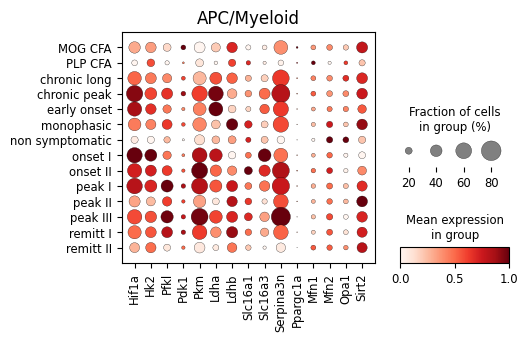

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


B cell


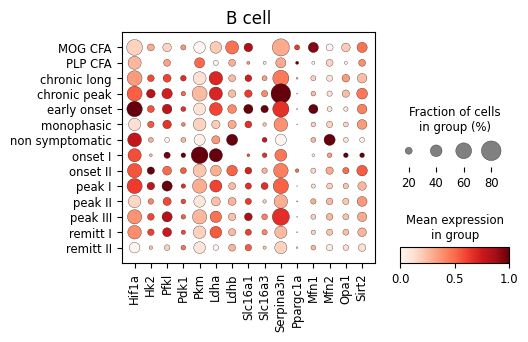

Monocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


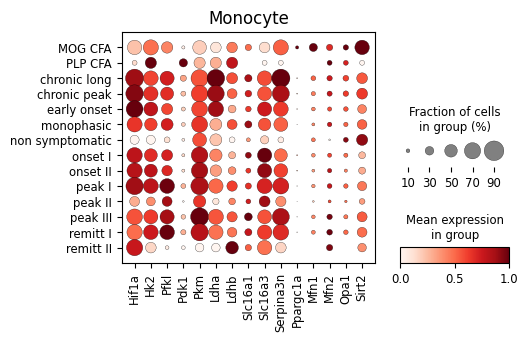

Endothelial


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


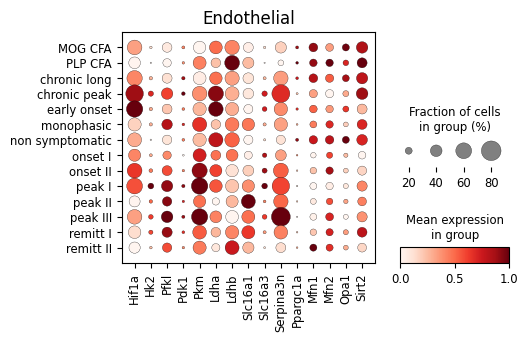

Oligodendrocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


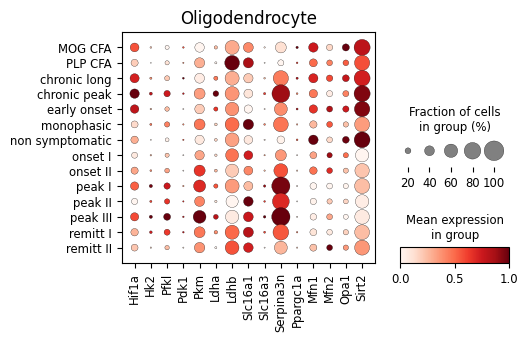

Fibroblast


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


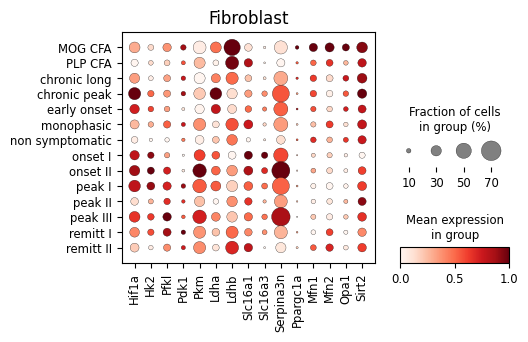

Astrocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


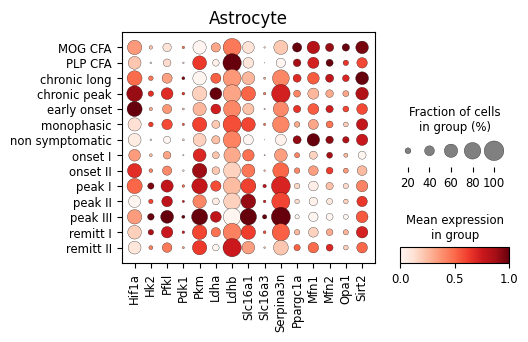

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Ependymal


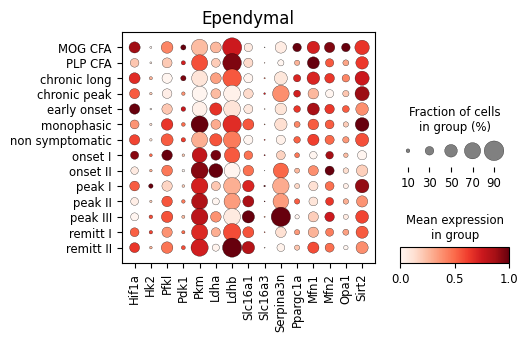

Glial-like


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


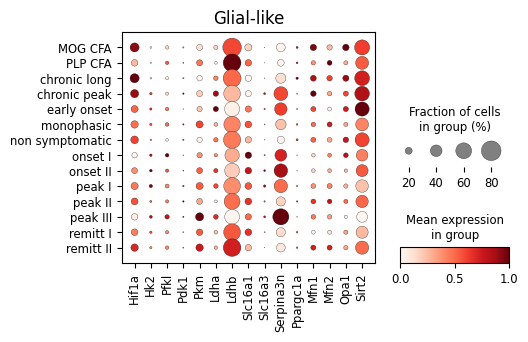

Foamy Myeloid


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


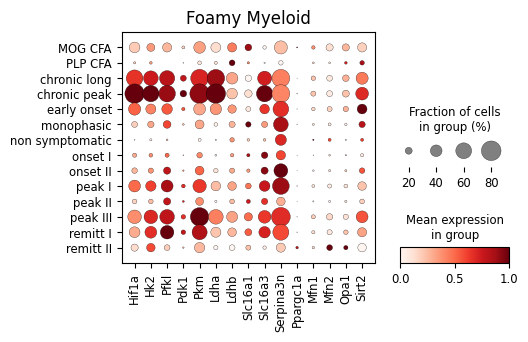

Monocyte (inflammatory)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


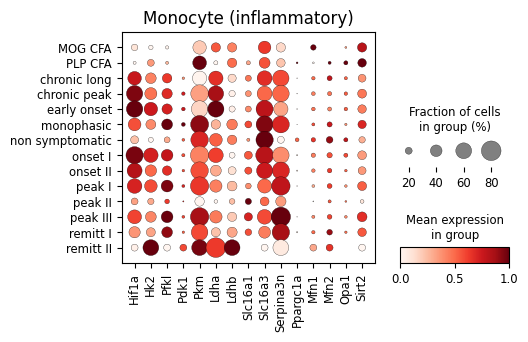

Microglia


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


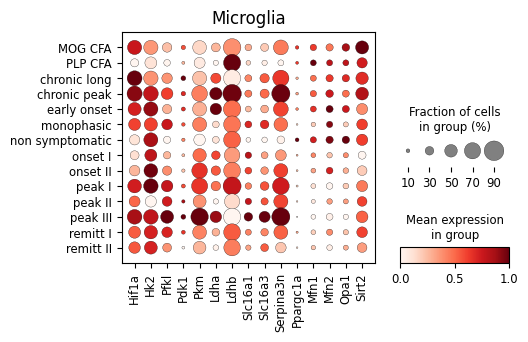

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Pericyte


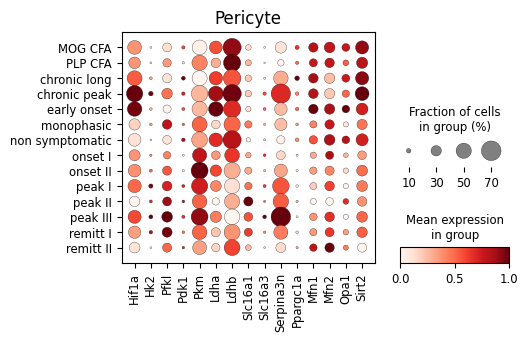

OPC


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


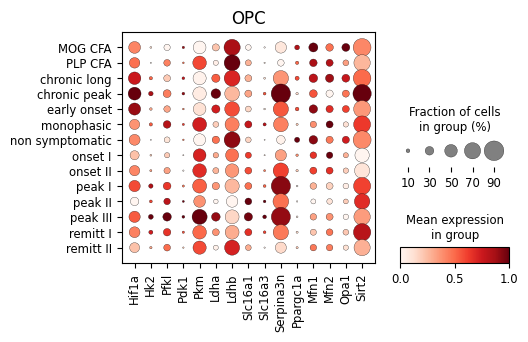

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Dendritic cell


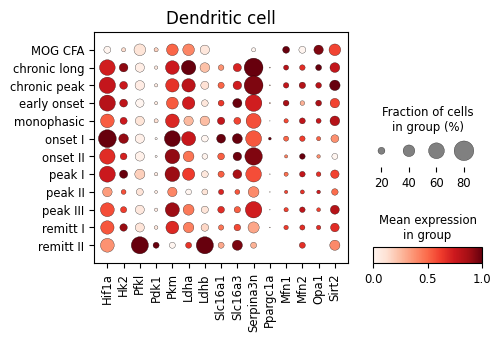

Mixed glia-vascular


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


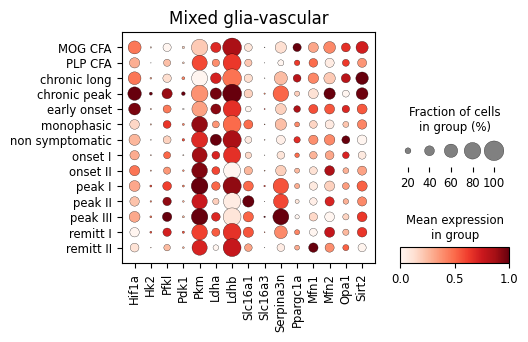

T cell (cycling)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


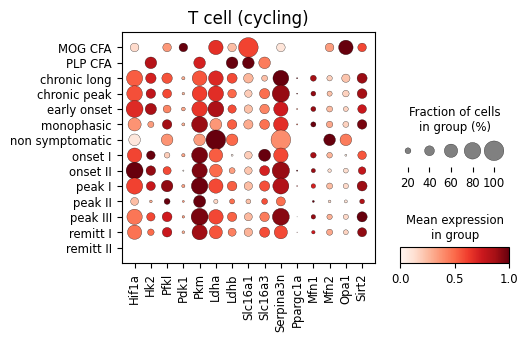

Fibroblast (cycling)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


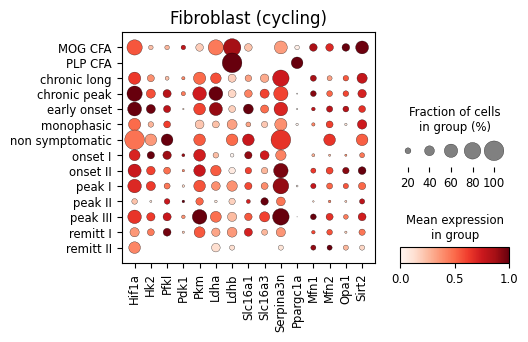

Metabolic-like


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


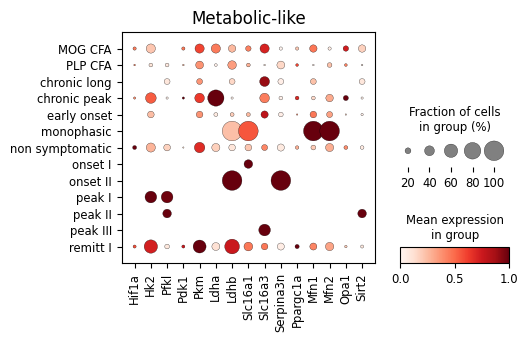

In [17]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']

for cell in adata.obs.celltype_merged.unique():
    print(cell)
    # Create dotplot (returns a dict of Figures when var_names is a dict)
    sc.pl.dotplot(
        adata[adata.obs.celltype_merged == cell],
        var_names=genes,
        groupby="course",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=False,
        figsize=(5, 3),
        #categories_order=['Ctrl','Early','Peak','Late'],
        title=cell
    )


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


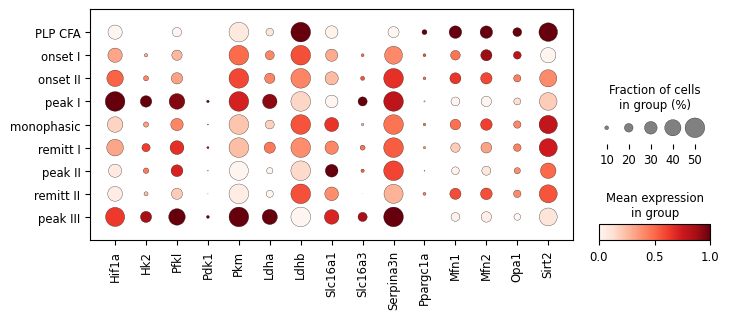

In [18]:
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'  # keep text editable

dp = sc.pl.dotplot(
    adata[adata.obs.model == 'RR'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['PLP CFA','onset I','onset II','peak I','monophasic','remitt I','peak II','remitt II','peak III'],
    figsize=(8,3),
)
#dp.savefig("../../data/plots/bioenergetic_map_RR.svg")

In [19]:
mask = (adata.obs["model"] == "Chronic") & (adata.obs["course"] == "remitt II")
adata.obs.loc[mask, "model"] = "RR"


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


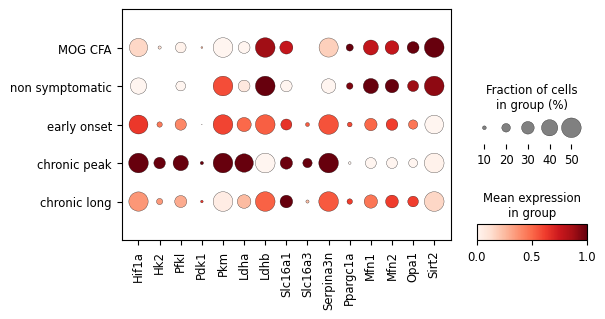

In [20]:
dp = sc.pl.dotplot(
    adata[adata.obs.model == 'Chronic'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(6, 3),
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


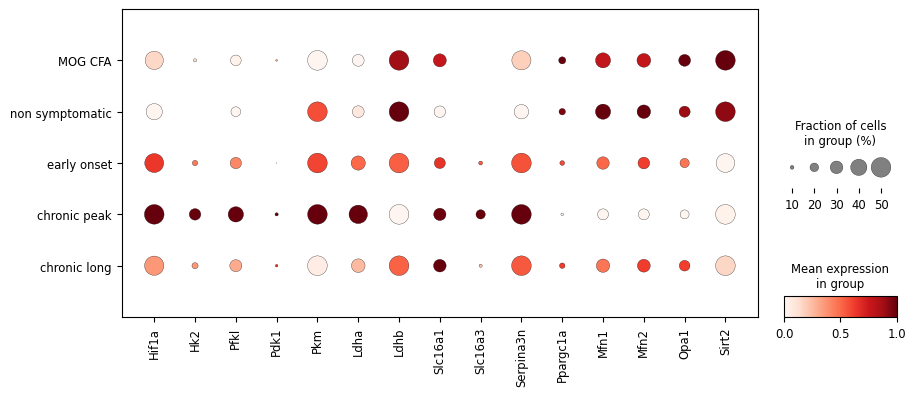

In [21]:
dp = sc.pl.dotplot(
    adata[adata.obs.model == 'Chronic'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(10, 4),
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [22]:
ordered_cell_types = [
    'Neuron',                      # Excitatory/inhibitory signal transmission, main targets of neurodegeneration
    'OPC',                         # Oligodendrocyte precursor cells, proliferative, remyelination potential
    'OPC (cycling)',               # Actively dividing OPCs during repair or inflammation
    'Oligodendrocyte',              # Myelinating glia, maintain axonal conduction, metabolically support neurons
    'DA-Oligodendrocyte',          # Disease-associated oligodendrocytes, altered myelin/lipid metabolism
    'Astrocyte',                   # Structural/metabolic support, blood-brain barrier maintenance, neurotransmitter cycling
    'DA-Astrocyte',                # Reactive astrocytes with pro- or anti-inflammatory phenotypes
    'Ependymal',                   # Line ventricles/central canal, regulate cerebrospinal fluid composition
    'Microglia (homeostatic)',     # CNS-resident immune cells in surveillance mode
    'Microglia (intermediate)',    # Transitional activation states, partly inflammatory
    'Microglia (cycling)',         # Proliferating microglia during inflammatory expansion
    'Foamy Microglia',             # Lipid-laden microglia, often in demyelinated lesions
    'Monocyte',                    # Peripheral immune cells infiltrating CNS, non-inflammatory phenotype
    'Monocyte (inflammatory)',     # Infiltrating monocytes with pro-inflammatory transcriptional profile
    'APC/Myeloid',                  # Antigen-presenting myeloid cells, drive adaptive immune activation
    'Foamy Myeloid',               # Lipid-rich infiltrating myeloid cells, linked to chronic lesions
    'Dendritic cell',              # Professional antigen-presenting cells, activate T cells
    'T cell',                      # Adaptive immunity, immune surveillance
    'T cell (cycling)',            # Activated, proliferating T cxells during immune response
    'B cell',                      # Adaptive immunity, antibody production, antigen presentation
    'Endothelial',                 # Vascular lining cells, blood-brain barrier integrity
    'Pericyte',                    # Perivascular support, regulate blood flow and BBB permeability
    'Fibroblast',                  # ECM production, scar formation, meningeal fibrosis
    'Fibroblast (cycling)',        # Actively dividing fibroblasts in fibrosis/repair
    'Mixed glia-vascular',         # Hybrid or transitional population at glia–vascular interfaces
    'Glial-like',                  # Ambiguous glial phenotype, potentially progenitor or transitional
    'Metabolic-like'               # High metabolic activity, unclear lineage or specialized role
]

In [23]:
adata.X

<891821x5101 sparse matrix of type '<class 'numpy.float32'>'
	with 528065583 stored elements in Compressed Sparse Row format>

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


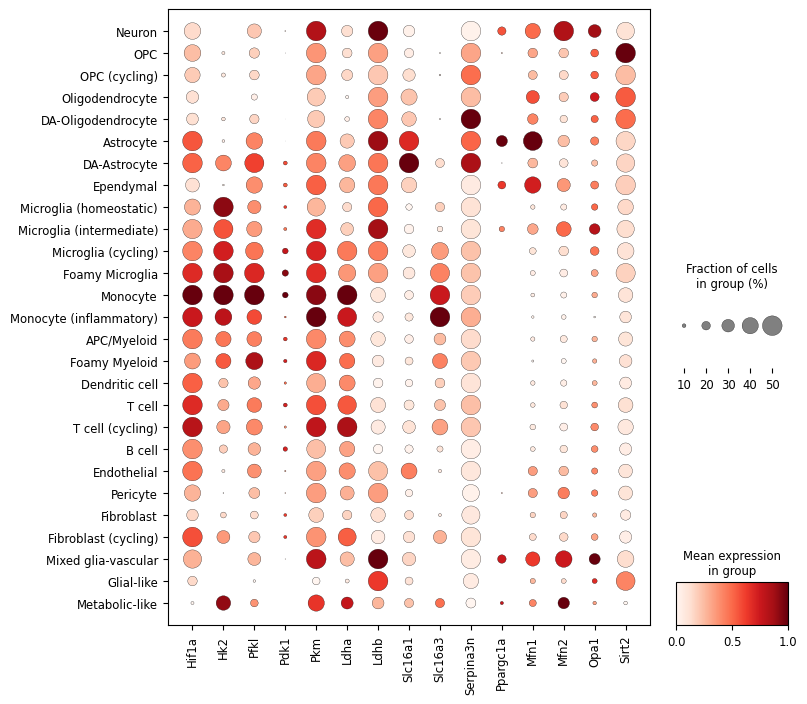

In [24]:
dp = sc.pl.dotplot(
    adata,
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 8),
    #vmin=-5,
    vmax=1,
    categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [25]:
list(adata.obs.celltype_merged.unique())

['Neuron',
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Endothelial',
 'Oligodendrocyte',
 'Fibroblast',
 'Astrocyte',
 'Ependymal',
 'Glial-like',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia',
 'Pericyte',
 'OPC',
 'Dendritic cell',
 'Mixed glia-vascular',
 'T cell (cycling)',
 'Fibroblast (cycling)',
 'Metabolic-like']

In [26]:
merge_map = {
    "Fibroblast (cycling)": "Fibroblast",
    
}

celltype_col = "sub_type_III"
adata.obs["celltype_merged"] = adata.obs[celltype_col].replace(merge_map)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


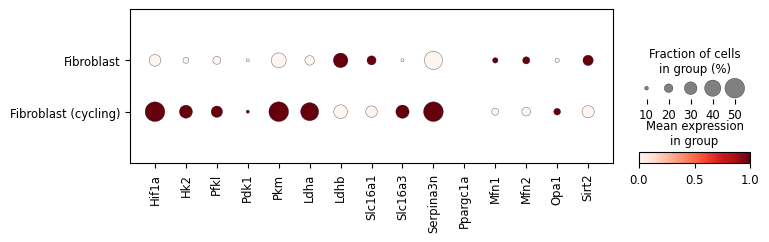

In [27]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('Fibro')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [28]:
list(adata.obs.sub_type_III.unique())

['Neuron',
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Endothelial',
 'Oligodendrocyte',
 'DA-Oligodendrocyte',
 'Fibroblast',
 'Astrocyte',
 'DA-Astrocyte',
 'Ependymal',
 'Glial-like',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia (cycling)',
 'Pericyte',
 'Microglia (intermediate)',
 'Microglia (homeostatic)',
 'OPC',
 'Foamy Microglia',
 'Dendritic cell',
 'Mixed glia-vascular',
 'T cell (cycling)',
 'Fibroblast (cycling)',
 'OPC (cycling)',
 'Metabolic-like']

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


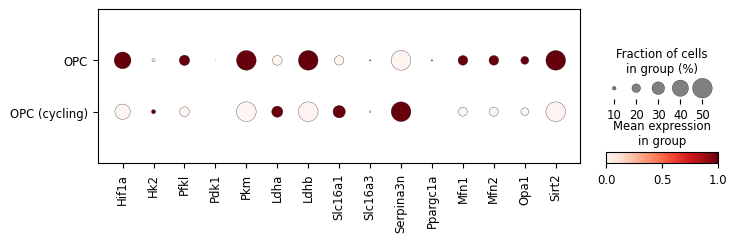

In [29]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('OPC')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


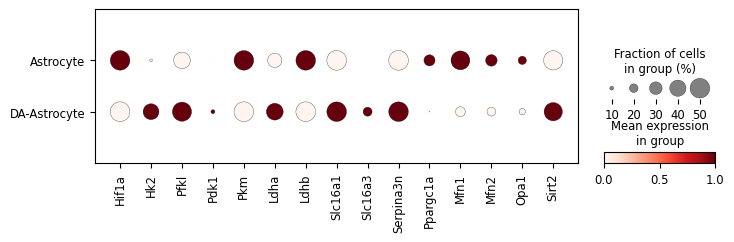

In [30]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('Astr')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [36]:
fibro.X.max()

4.176707

In [37]:
fibro = adata[adata.obs["sub_type_III"].isin(["Fibroblast (cycling)", "Fibroblast"])].copy()

sc.tl.rank_genes_groups(
    fibro,
    groupby="sub_type_III",
    reference="Fibroblast",  # baseline group
    method="wilcoxon",
)



In [38]:
deg_two = sc.get.rank_genes_groups_df(fibro, group="Fibroblast (cycling)")
deg_two.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,Mki67,36.125153,5.439973,9.138358e-286,4.661476e-282
1,Top2a,33.192932,5.524817,1.361534e-241,3.472592e-238
2,Lmnb1,30.110729,3.530182,3.506684e-199,5.962532e-196
3,Hist2h2bb,29.845678,3.366579,9.988656e-196,1.273803e-192
4,Anln,26.586580,4.023419,9.704160e-156,9.900185e-153


In [42]:
deg_two[deg_two.names.isin(genes)].sort_values(by = 'logfoldchanges',ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj
89,Slc16a3,12.647724,1.947955,1.151620e-36,5.340376e-35
21,Hif1a,19.240215,1.420014,1.704997e-82,3.478876e-80
69,Ldha,13.835664,1.376359,1.552957e-43,9.211201e-42
181,Hk2,9.347613,1.159019,8.964758e-21,2.069196e-19
139,Pkm,10.530929,0.599649,6.221785e-26,1.855984e-24
732,Pfkl,4.380744,0.308342,1.182745e-05,7.156800e-05
224,Serpina3n,8.530653,0.175770,1.455234e-17,2.689547e-16
1285,Opa1,2.550223,0.121053,1.076541e-02,3.678122e-02
2982,Pdk1,0.105870,0.019607,9.156856e-01,9.999164e-01
1811,Mfn2,1.478287,-0.038180,1.393311e-01,3.314963e-01


In [44]:
astro = adata[adata.obs["sub_type_III"].str.contains('Astro')].copy()

sc.tl.rank_genes_groups(
    astro,
    groupby="sub_type_III",
    reference="Astrocyte",  # baseline group
    method="wilcoxon",
)



/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
astro.obs.sub_type_III

cell_id
aadedgoa-1       Astrocyte
aaehedcl-1    DA-Astrocyte
aamfkdgh-1       Astrocyte
abhpnpan-1       Astrocyte
abjflace-1       Astrocyte
                  ...     
ohidokph-1       Astrocyte
ohijinoi-1       Astrocyte
ohikpojb-1       Astrocyte
ohjdbmif-1       Astrocyte
ohlngeln-1       Astrocyte
Name: sub_type_III, Length: 96878, dtype: category
Categories (2, object): ['Astrocyte', 'DA-Astrocyte']

In [51]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

def deg_two_groups_by_pattern(
    adata,
    pattern,                 # e.g. "Astro" or "Oligo"
    groupby="sub_type_III",  # column with subtypes
    reference="Astrocyte",   # baseline subgroup name
    target="DA-Astrocyte",   # subgroup to extract
    genes=None,              # optional gene list to highlight
    method="wilcoxon",
    use_raw=True,
    layer=None,
    min_cells_per_group=5,
    sort_by="logfoldchanges",
    ascending=False,
    make_plot=True,
    top_n=20
):
    """
    Run DE between `target` vs `reference` groups within a celltype pattern.
    Returns a tidy dataframe. Optionally makes a volcano plot.
    """
    mask = adata.obs[groupby].astype(str).str.contains(pattern, na=False)
    sub = adata[mask].copy()
    if sub.n_obs == 0:
        raise ValueError(f"No cells found for pattern '{pattern}' in obs['{groupby}'].")

    groups_present = sub.obs[groupby].astype(str).unique().tolist()
    if reference not in groups_present or target not in groups_present:
        raise ValueError(f"Reference '{reference}' or target '{target}' not in {groups_present}")

    counts = sub.obs[groupby].value_counts()
    if counts.get(reference, 0) < min_cells_per_group or counts.get(target, 0) < min_cells_per_group:
        raise ValueError(f"Too few cells: {target}={counts.get(target,0)}, {reference}={counts.get(reference,0)}")

    sc.tl.rank_genes_groups(
        sub,
        groupby=groupby,
        reference=reference,
        method=method,
        use_raw=use_raw,
        layer=layer
    )

    deg = sc.get.rank_genes_groups_df(sub, group=target)
    if genes is not None:
        deg = deg[deg["names"].isin(genes)]

    if sort_by in deg.columns:
        deg = deg.sort_values(sort_by, ascending=ascending)

    if make_plot and not deg.empty:
        plt.figure(figsize=(6,5))
        dfp = deg.copy()
        dfp["-log10p"] = -np.log10(dfp["pvals_adj"].replace(0, 1e-300))
        sns.scatterplot(
            data=dfp,
            x="logfoldchanges", y="-log10p",
            alpha=0.7, edgecolor=None
        )
        # highlight selected genes
        if genes is not None:
            df_high = dfp[dfp["names"].isin(genes)]
            sns.scatterplot(
                data=df_high, x="logfoldchanges", y="-log10p",
                color="red", s=50
            )
            for _, row in df_high.iterrows():
                plt.text(row["logfoldchanges"], row["-log10p"], row["names"],
                         fontsize=8, color="red")
        # highlight top N genes by significance
        else:
            top = dfp.nsmallest(top_n, "pvals_adj")
            for _, row in top.iterrows():
                plt.text(row["logfoldchanges"], row["-log10p"], row["names"],
                         fontsize=8)
        plt.axvline(0, color="grey", linestyle="--")
        plt.title(f"{target} vs {reference} ({pattern})")
        plt.xlabel("log2 fold change")
        plt.ylabel("-log10 adj p-value")
        plt.tight_layout()
        plt.show()

    return deg.reset_index(drop=True)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


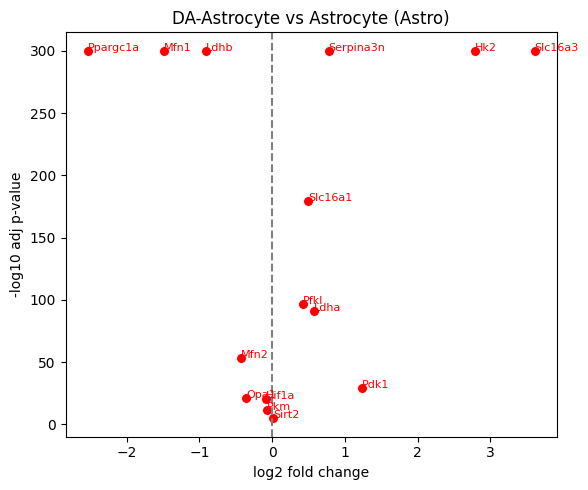

In [54]:
deg_ast = deg_two_groups_by_pattern(
    adata,
    pattern="Astro",
    reference="Astrocyte",
    target="DA-Astrocyte",
    genes=genes,      # highlight your metabolic gene set
    method="wilcoxon",
    use_raw=False, 
)